# **<center>Imports</center>**

In [165]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers.merging import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from skimage.io import imsave
import cv2

#Utilities
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# **<center>Data Collection</center>**

In [166]:
train_data_path = "photos/train/"
test_data_path = "photos/test/"

In [167]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(train_data_path, target_size=(256,256), batch_size=50, class_mode=None)

Found 2510 images belonging to 1 classes.


In [168]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(test_data_path, target_size=(256, 256), batch_size=50, class_mode=None)

Found 2510 images belonging to 1 classes.


In [169]:
def prepareInputData(path, h, w):
    X=[]
    y=[]
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (w, h)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X.append(img_l)
            y.append(img_ab)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [170]:
X_train,y_train = prepareInputData(train_data_path + "train_data/", 256, 256)
X_test, y_test = prepareInputData(test_data_path + "test_data/", 256, 256)

In [171]:
X_train[0]

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]], dtype=float32)

In [172]:
y_train[6]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)

# **<center>Making the Model</center>**

In [173]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [174]:
networkInput = Input(shape=(256, 256,1))
networkOutput = createModel(networkInput)
model = Model(inputs=networkInput, outputs=networkOutput)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='batch_normalization_29/FusedBatchNormV3:0', description="created by layer 'batch_normalization_29'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 32), dtype=tf.float32, name=None), name='batch_normalization_32/FusedBatchNormV3:0', description="created by layer 'batch_normalization_32'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")


In [175]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [176]:
ALPHA = 0.5
BETA = 0.5

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [177]:
ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [178]:
def custom_loss(y_true, y_pred):
    # Split the predicted and ground truth tensors into a and b channels
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    # Compute the Euclidean distance between a and b channels 4
    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    
    # Compute hue and saturation from a and b channels of predicted image
    hue_true = tf.math.atan2(b_true, a_true)
    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    hue_pred = tf.math.atan2(b_pred, a_pred)
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    
    # Define the weighting factor for emphasizing saturation over hue
    saturation_weight = 2.0
    
    # Compute the weighted hue-saturation loss
    hue_saturation_loss = tf.square(hue_pred - hue_true) + saturation_weight * tf.square(saturation_pred - saturation_true)
    
    # Combine the color loss and hue-saturation loss
    total_loss = tf.add(color_loss,hue_saturation_loss)
    
    # Return the mean loss over the batch
    return tf.reduce_mean(tf.sqrt(total_loss))


In [179]:
LEARNING_RATE = 0.01
model.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss=custom_loss)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 256, 256, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_28 (LeakyReLU)     (None, 256, 256, 16  0           ['conv2d_32[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 32  18464       ['batch_normalization_33[0][0]'] 
                                )                                                                 
                                                                                                  
 leaky_re_lu_34 (LeakyReLU)     (None, 256, 256, 32  0           ['conv2d_38[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 256, 256, 32  128        ['leaky_re_lu_34[0][0]']         
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_39

In [190]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

history = model.fit(GenerateInputs(X_train,y_train),epochs=250,verbose=1,steps_per_epoch=15, shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=25)

Epoch 1/250


15/15 [==============================] - 31s 2s/step - loss: 2.4526 - val_loss: 2.4626
Epoch 2/250
15/15 [==============================] - 32s 2s/step - loss: 2.4515 - val_loss: 2.4633
Epoch 3/250
15/15 [==============================] - 36s 2s/step - loss: 2.4523 - val_loss: 2.4627
Epoch 4/250
15/15 [==============================] - 31s 2s/step - loss: 2.4533 - val_loss: 2.4612
Epoch 5/250
15/15 [==============================] - 27s 2s/step - loss: 2.4526 - val_loss: 2.4575
Epoch 6/250
15/15 [==============================] - 29s 2s/step - loss: 2.4524 - val_loss: 2.4517
Epoch 7/250
15/15 [==============================] - 29s 2s/step - loss: 2.4521 - val_loss: 2.4412
Epoch 8/250
15/15 [==============================] - 28s 2s/step - loss: 2.4527 - val_loss: 2.3755
Epoch 9/250
15/15 [==============================] - 31s 2s/step - loss: 2.4535 - val_loss: 2.4588
Epoch 10/250
15/15 [==============================] - 27s 2s/step - loss: 2.4541 - val_loss: 2.3639
Epoch 11/250
15/15 [=

In [191]:
data = {
 #   "acc": list(history.history["acc"]),
#    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [197]:
chart = Line("Model Results")
chart.set_options(
    labels=list(range(170)),
    x_label="Epoch",
    y_label="Percent",
)


#chart.add_series("acc", data["acc"])
#chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

# **<center>Testing the Model</center>**

In [193]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [213]:
TestImagePath="photos/train/train_data/kfdR-d3lHHg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = model.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 221ms/step
Prediction made
reshaped


In [185]:
Prediction.shape

(256, 256, 2)

In [199]:
np.unique(Prediction[:,:,1])

array([-47.019333, -46.915592, -46.87202 , ..., 127.999855, 127.99996 ,
       128.      ], dtype=float32)

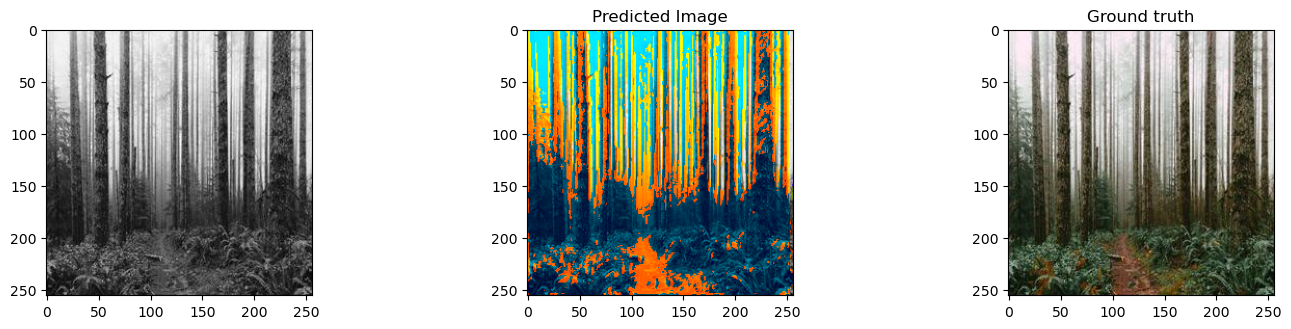

In [214]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img_1, cv2.COLOR_RGB2Lab)
img_[:,:,1] = Prediction[:,:,0]
img_[:,:,2] = Prediction[:,:,1]
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

1/1 [==============================] - 0s 206ms/step
(1, 256, 256, 1)
(1, 256, 256, 2)


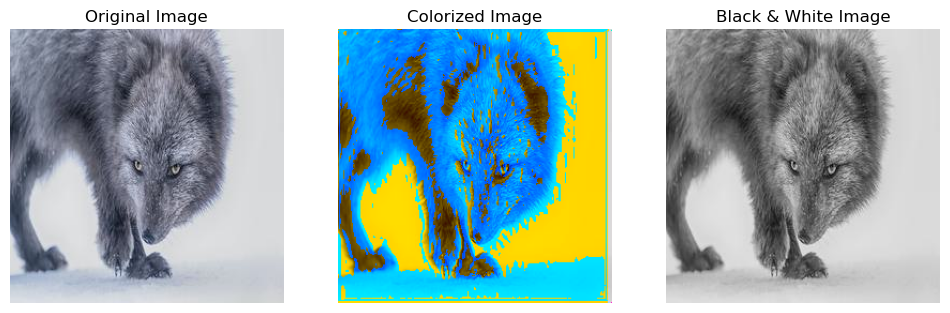

In [206]:
# Load a sample test image
TestImagePath = "photos/train/train_data/ZZhlmDHiQTQ.jpg"
img = cv2.imread(TestImagePath)

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()


In [189]:
np.unique(Prediction[:,:,0])

array([-128.      , -127.99999 , -127.99998 , ...,  127.999985,
        127.99999 ,  128.      ], dtype=float32)